# Problem Analysis

In the highly competitive banking industry, it is important for banks to maintain their competitiveness by focusing their marketing efforts on campaigns that generate the highest return on investment (ROI). However, banks often struggle to quantify the ROI for different marketing efforts, making it difficult to determine which campaigns generate the highest profitability and long-term customer value. Therefore, being able to measure and predict the cost-effectiveness of marketing campaigns is crucial for efficient allocation of marketing budgets, ensuring that a bank employs the most effective marketing strategy.

To tackle this challenge, we aim to develop a model that can predict the ROI of various bank marketing campaigns based on key influencing factors such as conversion rate, customer lifetime value (CLV), and acquisition cost. Each of these variables will be estimated using 3 individual models, using campaign-specific features such as campaign type (email marketing, telemarketing, etc), campaign duration, target audience, campaign langauge, and campaign timeframe as inputs. Then, the outputs of these 3 sub-models will be used to develop a model to predict ROI.

Through this, not only are we able to predict and quanitfy the cost-effectiveness of a given marketing campaign, but also that of a general marketing strategy. By identifying the most cost-effective approach, banks can make data-driven decisions to improve their marketing strategies.


General outline:
1. using customer_id as the shared column, join engagement_details with customer.csv, adding the CLV column from customer.csv to engagement_details
2. in the engagement_details dataset, perform a GROUP BY, with the grouping being determined by campaign_id. the resulting table at this step should have the columns campaign_id, and avg_CLV
to obtain avg_CLV: calculate the average CLV for each campaign across various engagements
3. merge campaigns.csv and the resulting table above on campaign_id. the reuslting dataset should include the following columns:
campaign_id, campaign_type, target_audience, campaign_duration, campaign_language, conversion_rate, acquisition_cost, avg_clv, roi
4. conduct EDA
5. train 3 models to predict CLV, acquisition cost, conversion rate
6. train a model to predict ROI 

# Load datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load datasets
campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df =  pd.read_csv("../../data/processed/customer.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
engagement_details_df.head(), customer_df.head(), campaigns_df.head()
campaigns_df

,campaign_id,campaign_type,target_audience,campaign_duration,conversion_rate,acquisition_cost,roi,campaign_language,impressions,clicks
0,25,Search Engine Optimization,35-44,15,0.1161,16230.45,4.85,Mandarin,14665,1703.0
1,11,Email Marketing,35-44,75,0.0471,13406.29,3.50,Mandarin,33011,1555.0
2,41,Affiliate Marketing,35-44,30,0.1332,9051.65,1.99,Mandarin,7142,951.0
3,35,Display Advertising,35-44,60,0.1021,3788.69,2.76,Mandarin,12935,1321.0
4,29,Search Engine Optimization,55+,15,0.0620,2967.56,3.29,German,22232,1378.0
...,...,...,...,...,...,...,...,...,...,...
94,64,Affiliate Marketing,25-34,30,0.0223,2284.55,4.78,English,17037,380.0
95,51,Affiliate Marketing,35-44,15,0.1073,7489.93,4.66,French,9445,1013.0
96,44,Display Advertising,25-34,15,0.0857,25968.17,2.32,Mandarin,35907,3077.0
97,14,Email Marketing,45-54,45,0.0511,6336.82,1.80,English,30402,1554.0


# Data preprocessing
#### Obtain derived variables

In [2]:
# Join engagement_details with customer.csv on customer_id, adding CLV column
engagement_details_with_clv = engagement_details_df.merge(
    customer_df[['customer_id', 'customer_lifetime_value']],
    on='customer_id',
    how='left'
)

# Compute the average CLV per campaign
avg_clv_per_campaign = engagement_details_with_clv.groupby('campaign_id', as_index=False)['customer_lifetime_value'].mean()
avg_clv_per_campaign.rename(columns={'customer_lifetime_value': 'avg_clv'}, inplace=True)

# Merge campaigns.csv with avg_clv_per_campaign on campaign_id
merged_campaigns = campaigns_df.merge(avg_clv_per_campaign, on='campaign_id', how='left')

# Select and rearrange the required columns
df = merged_campaigns[['campaign_id', 'campaign_type', 'target_audience', 'campaign_duration',
                       'campaign_language', 'conversion_rate', 'acquisition_cost', 'avg_clv', 'roi']]
df

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
0,25,Search Engine Optimization,35-44,15,Mandarin,0.1161,16230.45,315.308303,4.85
1,11,Email Marketing,35-44,75,Mandarin,0.0471,13406.29,298.196294,3.50
2,41,Affiliate Marketing,35-44,30,Mandarin,0.1332,9051.65,323.314662,1.99
3,35,Display Advertising,35-44,60,Mandarin,0.1021,3788.69,315.446489,2.76
4,29,Search Engine Optimization,55+,15,German,0.0620,2967.56,314.731233,3.29
...,...,...,...,...,...,...,...,...,...
94,64,Affiliate Marketing,25-34,30,English,0.0223,2284.55,319.604884,4.78
95,51,Affiliate Marketing,35-44,15,French,0.1073,7489.93,313.674231,4.66
96,44,Display Advertising,25-34,15,Mandarin,0.0857,25968.17,315.276193,2.32
97,14,Email Marketing,45-54,45,English,0.0511,6336.82,314.311966,1.80


In [3]:
distinct_values = {
    'campaign_duration': sorted(df['campaign_duration'].unique()),
    'campaign_type': sorted(df['campaign_type'].unique()),
    'target_audience': sorted(df['target_audience'].unique()),
    'campaign_language': sorted(df['campaign_language'].unique())
}

distinct_values

{'campaign_duration': [15, 30, 45, 60, 75],
 'campaign_type': ['Affiliate Marketing',
  'Display Advertising',
  'Email Marketing',
  'Search Engine Optimization',
  'Telemarketing'],
 'target_audience': ['18-24', '25-34', '35-44', '45-54', '55+'],
 'campaign_language': ['English', 'French', 'German', 'Mandarin', 'Spanish']}

#### Data transformation

In [4]:
# perform target encoding for categorical variables
categorical_cols = ['campaign_type', 'target_audience', 'campaign_language']
df_encoded = df.copy()
for col in categorical_cols:
    target_mean = df_encoded.groupby(col)['roi'].mean()
    df_encoded[col + '_encoded'] = df_encoded[col].map(target_mean)
df_encoded.drop(columns=categorical_cols, inplace=True)
df_encoded


,campaign_id,campaign_duration,conversion_rate,acquisition_cost,avg_clv,roi,campaign_type_encoded,target_audience_encoded,campaign_language_encoded
0,25,15,0.1161,16230.45,315.308303,4.85,3.218750,3.448462,3.225600
1,11,75,0.0471,13406.29,298.196294,3.50,2.913333,3.448462,3.225600
2,41,30,0.1332,9051.65,323.314662,1.99,3.257647,3.448462,3.225600
3,35,60,0.1021,3788.69,315.446489,2.76,3.337000,3.448462,3.225600
4,29,15,0.0620,2967.56,314.731233,3.29,3.218750,3.128000,3.281429
...,...,...,...,...,...,...,...,...,...
94,64,30,0.0223,2284.55,319.604884,4.78,3.257647,3.518400,3.161111
95,51,15,0.1073,7489.93,313.674231,4.66,3.257647,3.448462,3.332308
96,44,15,0.0857,25968.17,315.276193,2.32,3.337000,3.518400,3.225600
97,14,45,0.0511,6336.82,314.311966,1.80,2.913333,2.513913,3.161111


In [5]:
# Create a reference dictionary mapping each categorical column to its target-encoded values
encoding_reference = {}

for col in categorical_cols:
    target_mean = round(df.groupby(col)['roi'].mean(), 2)
    encoding_reference[col] = target_mean.to_dict()
encoding_reference

{'campaign_type': {'Affiliate Marketing': 3.26,
  'Display Advertising': 3.34,
  'Email Marketing': 2.91,
  'Search Engine Optimization': 3.22,
  'Telemarketing': 3.29},
 'target_audience': {'18-24': 4.1,
  '25-34': 3.52,
  '35-44': 3.45,
  '45-54': 2.51,
  '55+': 3.13},
 'campaign_language': {'English': 3.16,
  'French': 3.33,
  'German': 3.28,
  'Mandarin': 3.23,
  'Spanish': 3.06}}

# Exploratory Data Analysis

#### Summary Statistics

In [6]:
# Compute correlation matrix excluding non-numeric columns
numeric_df = df.select_dtypes(include=['number']).drop(columns=['campaign_id'])
numeric_df.describe()
correlation_matrix = numeric_df.corr()
numeric_df.describe()

,campaign_duration,conversion_rate,acquisition_cost,avg_clv,roi
count,99.000000,99.000000,99.000000,99.000000,99.000000
mean,46.060606,0.081357,10086.347778,314.337804,3.229697
std,21.774268,0.040839,9870.087694,10.653967,0.969824
min,15.000000,0.010400,186.320000,289.189518,1.500000
25%,30.000000,0.046000,3224.930000,307.650706,2.420000
50%,45.000000,0.081400,6914.600000,314.731233,3.160000
75%,60.000000,0.120750,13198.455000,321.346319,3.955000
max,75.000000,0.149100,50987.320000,341.851471,4.980000


The variable acquisition_cost has high variability, we will reduce its spread by performing log-transformation.
Furthermore, it also has a significantly larger scale compared to conversion_rate and avg_clv, we should consider feature scaling to ensure consistency across input variables. 

In [7]:
# Log-transform the acquisition_cost column
df_encoded['log_acquisition_cost'] = np.log(df_encoded['acquisition_cost'])

#### Categorical variables
First, let's explore any direct relationships between the categorical (campaign-related) features and the ROI.

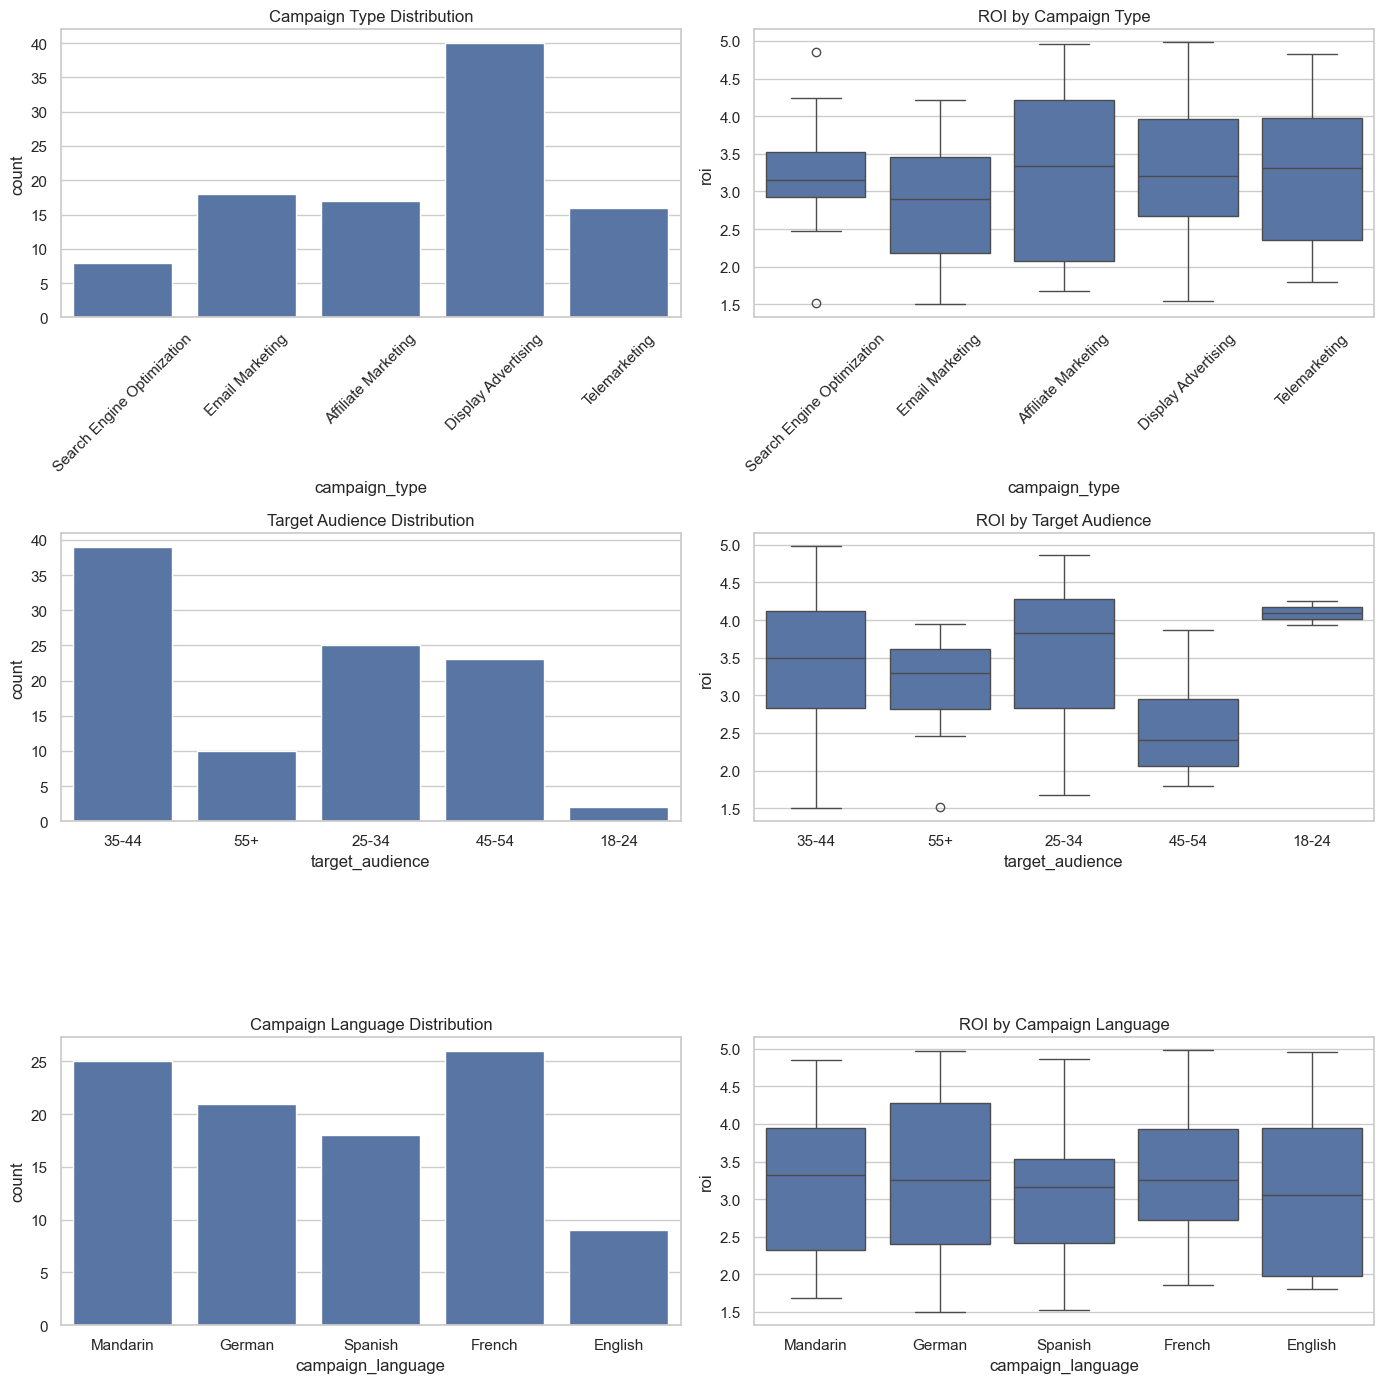

In [8]:
sns.set(style="whitegrid")

# Plot distributions and ROI means for each categorical variable
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# Campaign Type
sns.countplot(data=df, x='campaign_type', ax=axes[0, 0])
axes[0, 0].set_title('Campaign Type Distribution')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df, x='campaign_type', y='roi', ax=axes[0, 1])
axes[0, 1].set_title('ROI by Campaign Type')
axes[0, 1].tick_params(axis='x', rotation=45)

# Target Audience
sns.countplot(data=df, x='target_audience', ax=axes[1, 0])
axes[1, 0].set_title('Target Audience Distribution')

sns.boxplot(data=df, x='target_audience', y='roi', ax=axes[1, 1])
axes[1, 1].set_title('ROI by Target Audience')

# Campaign Language
sns.countplot(data=df, x='campaign_language', ax=axes[2, 0])
axes[2, 0].set_title('Campaign Language Distribution')

sns.boxplot(data=df, x='campaign_language', y='roi', ax=axes[2, 1])
axes[2, 1].set_title('ROI by Campaign Language')

plt.tight_layout()
plt.show()

Campaign types like Affiliate Marketing and Display Advertising might have wider ROI variation, suggesting that these camapign types may be more risky or unpredictable.
Campaigns that target younger age groups (18-24, 24-34) seem to have higher median ROI. This might suggest that campaigns targeting youths aged 18-34 are generally more profitable.
Median ROI is similar across campaign languages, which might suggest that the language used in a campaign does not significantly impact the profitability of a campaign directly.

Now, let's explore the relationships between the categorical campaign-related features and CLV, acquisition cost and conversion rate respectively. These insights may drive our model selection for each sub-model.

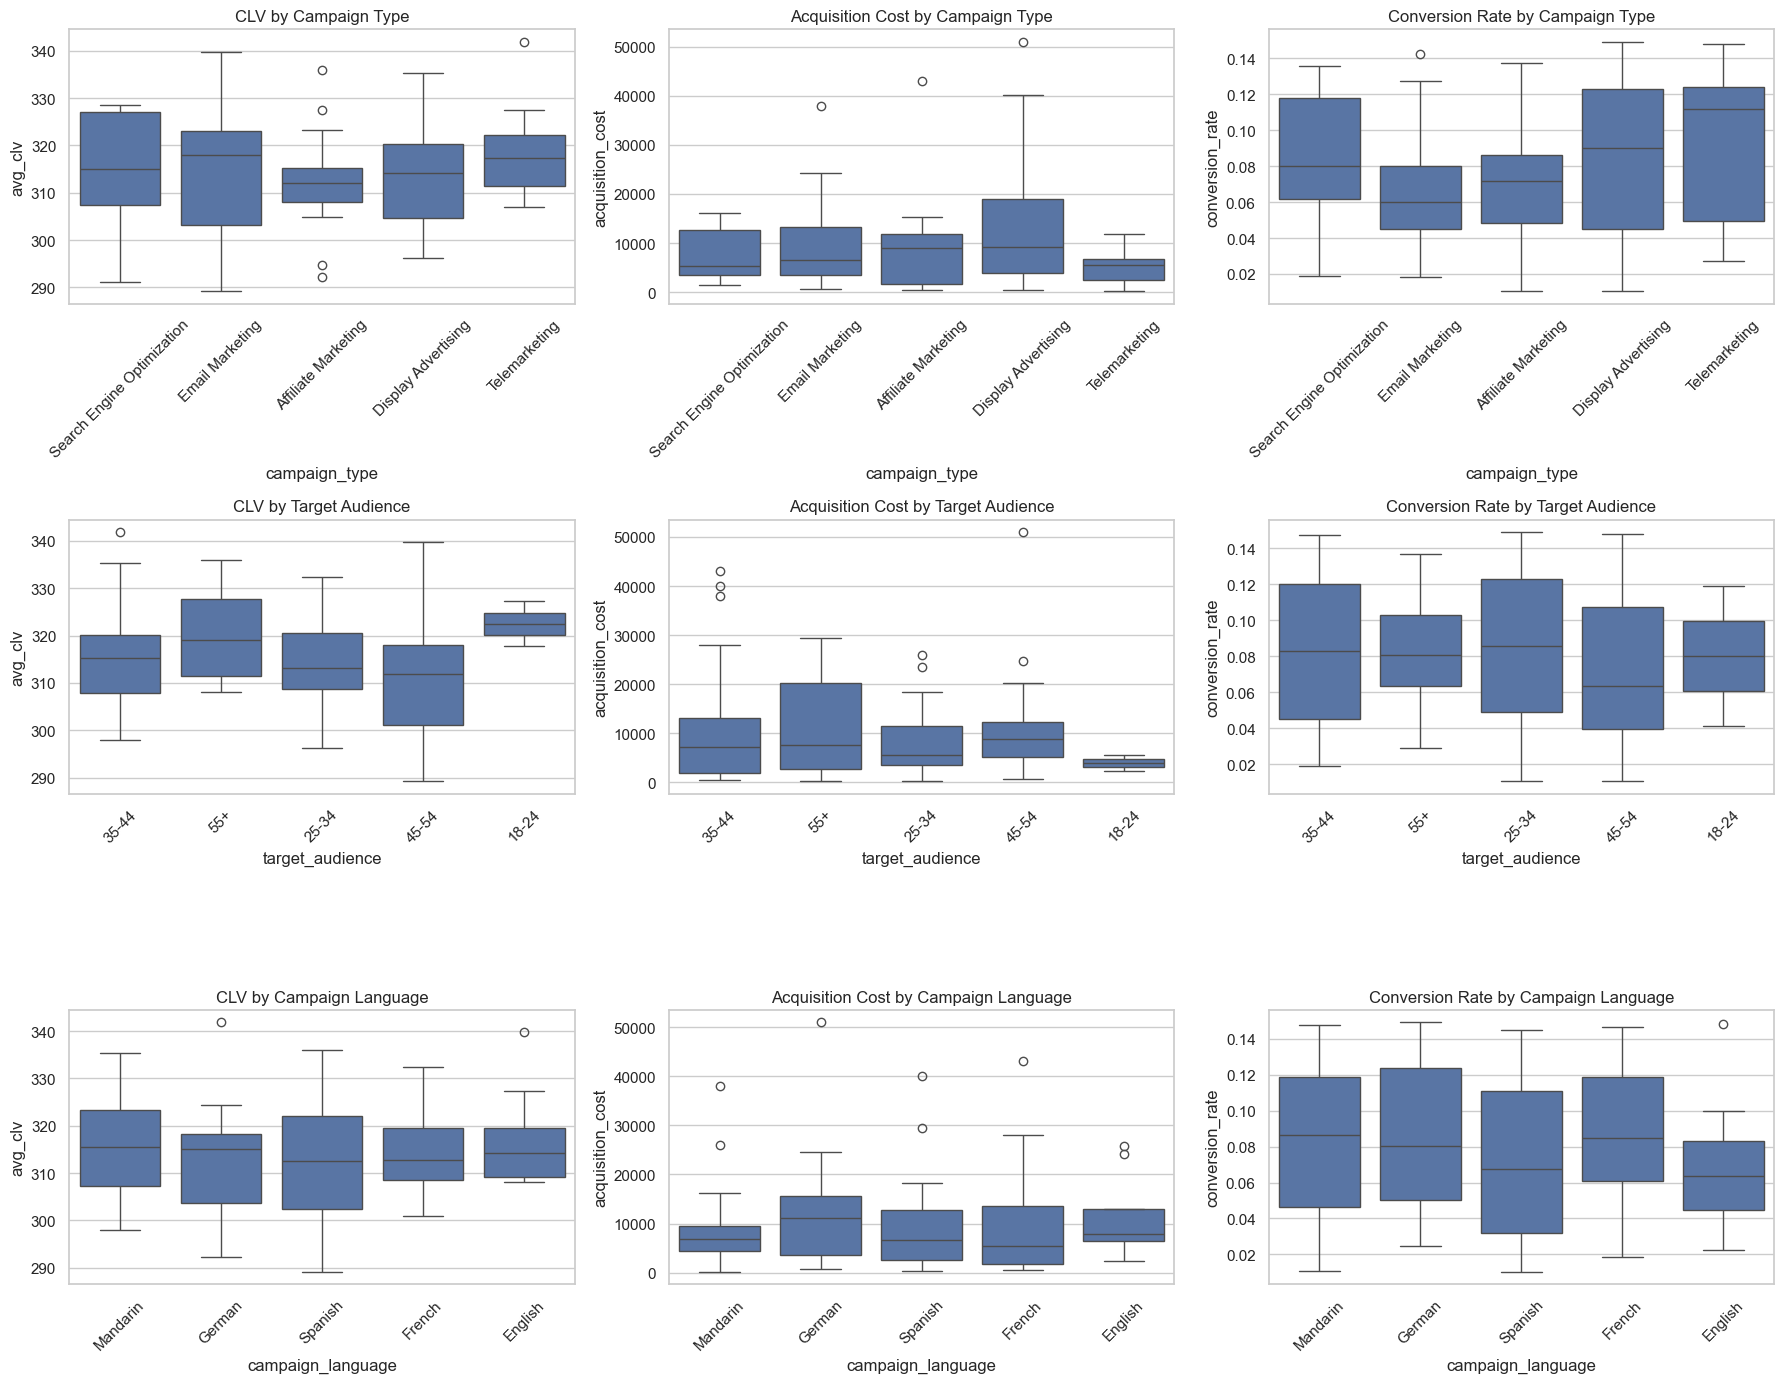

In [9]:
# Configure grid for categorical feature vs CLV, Cost, Conversion Rate
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
categorical_vars = ['campaign_type', 'target_audience', 'campaign_language']
numerical_targets = ['avg_clv', 'acquisition_cost', 'conversion_rate']
titles = ['CLV', 'Acquisition Cost', 'Conversion Rate']

# Iterate through each combination and plot boxplots
for i, cat in enumerate(categorical_vars):
    for j, num in enumerate(numerical_targets):
        sns.boxplot(data=df, x=cat, y=num, ax=axes[i, j])
        axes[i, j].set_title(f'{titles[j]} by {cat.replace("_", " ").title()}')
        axes[i, j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

CLV model:\
Email marketing has the highest CLV among all camapign types, while Affliate marketing has the lowest. However, median CLV is relatively similar across campaign types.\
Target audience shows the strongest relationship with CLV. Campaigns with younger target audiences (18-24,25-34) generally have higher CLVs, while campaigns targeted at older age groups (45-54) seem to have the lowest CLV. \
Median CLV is relatively stable across languages, suggesting that campaign language has a weaker influence on CLV than other factors.\
Given that CLV has low variance, we should use a non linear model that can capture subtle patterns. We will explore **Random Forest Regressor** for this.


Acquisition cost model:\
Large variation for Display Advertising, compared to other campaign types.\
Costs are generally lower for younger age groups, variation is higher for older age groups.\
Greater variation for French and German compared to other languages.\
Given that acquisition cost has high variance, and the relationship between the input features and the response variable is likely non-linear, we will use **XGBoost** to prevent overfitting.


Conversion Rate model:\
High variance across all campaign types, with email marketing with the lowest median and telemarketing with the highest median. \
Slightly higher conversion rates for younger audiences, with target group 45-54 having the lowest conversion rate.\
Lowest conversion rates for English campaigns, but overall consistent median across campaign languages.\
Similar to acquisition cost model, the relationship between the input features and the response variable is likely non-linear, we will use **XGBoost** to ensure sufficient generalization.

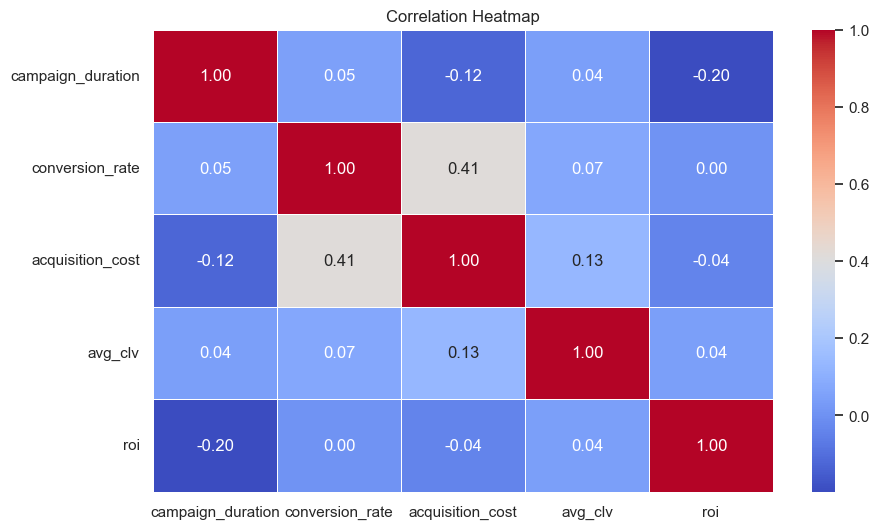

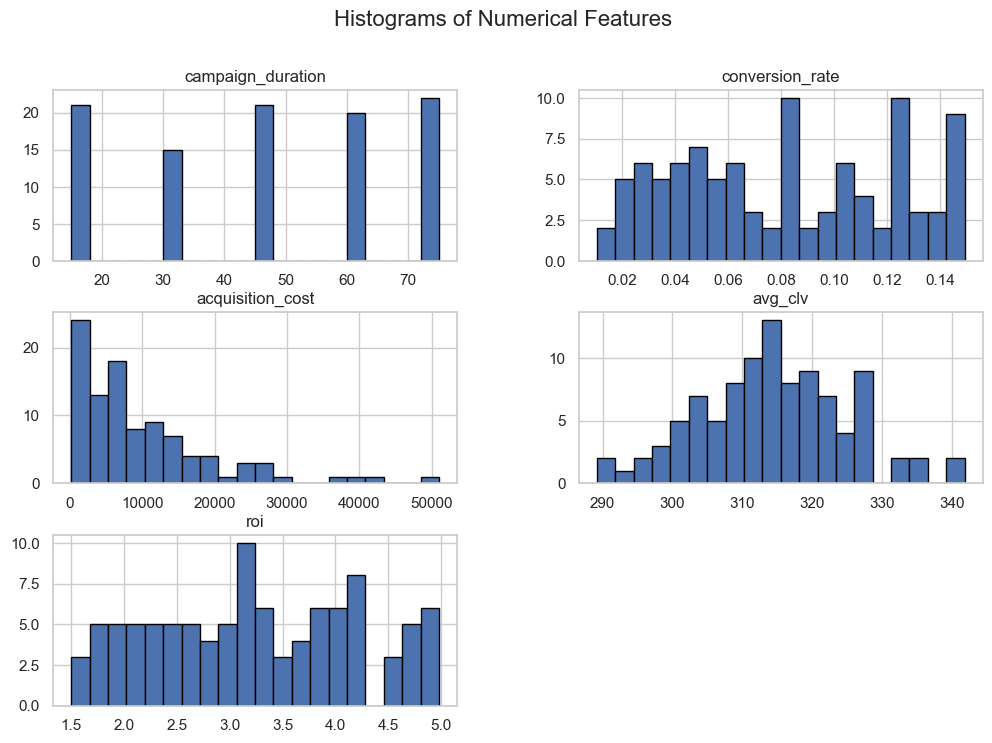

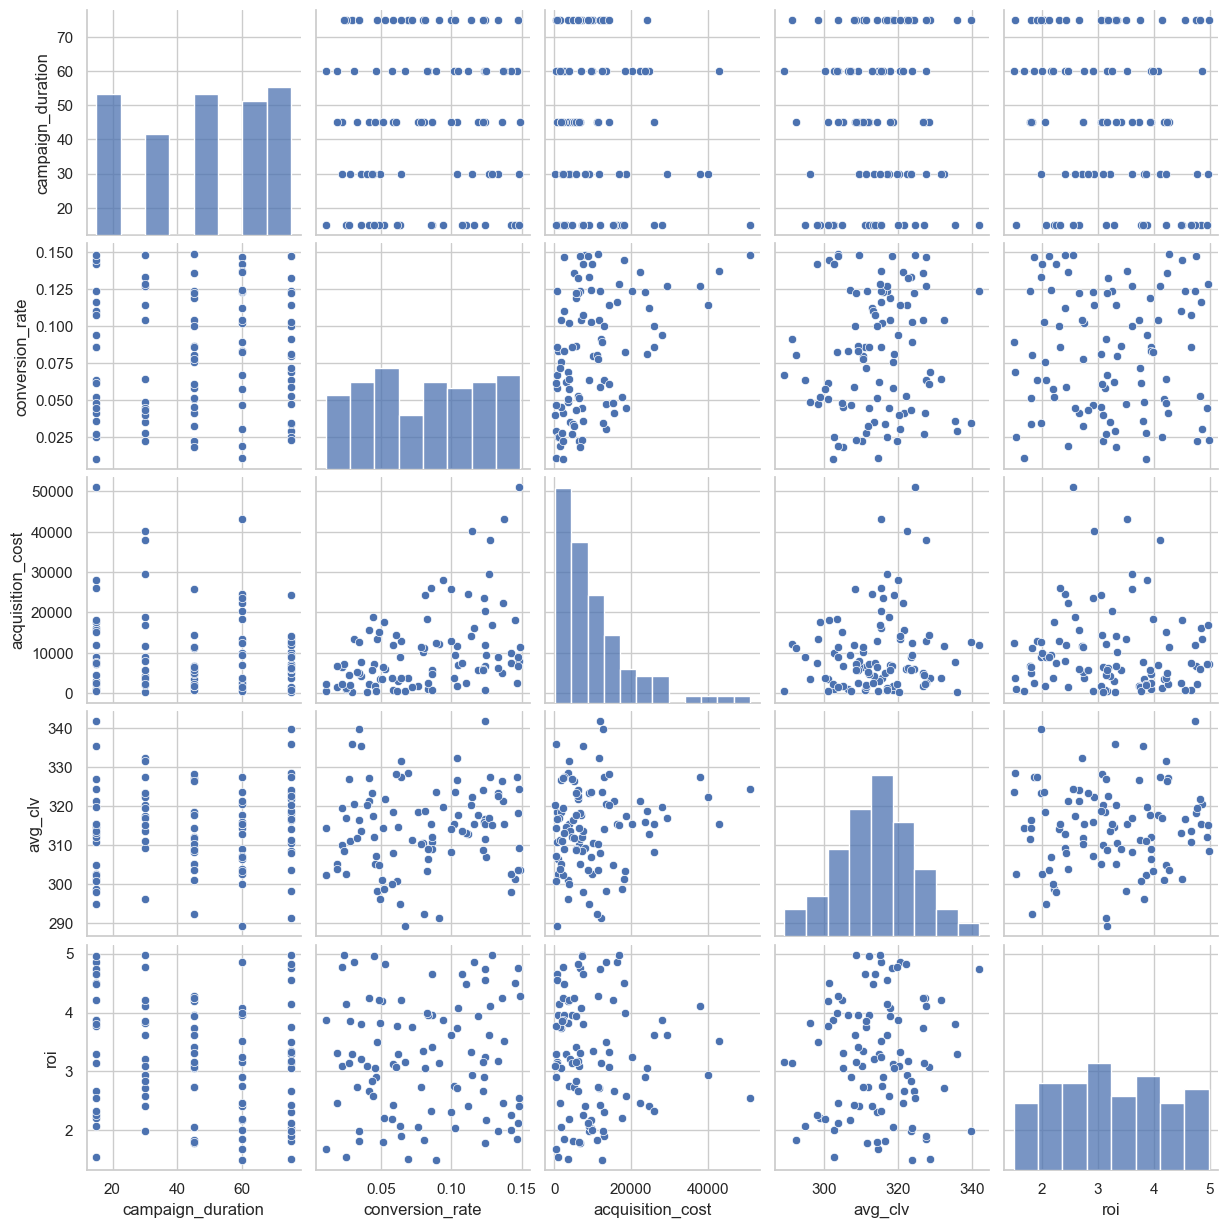

In [10]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Histograms for numerical features
numeric_df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

# Pairplot for better understanding feature distributions and relationships
sns.pairplot(numeric_df)
plt.show()

Furthermore, there is almost no linear relationship between customer lifetime value, conversion rate, and acquisition cost. Hence, we should consider nonlinear models to model ROI. ( OR USE FORMULA, TBC)

#### Summary of approach
CLV sub-model: Random Forest Regressor\
Acquisition cost sub-model: XGBoost\
Conversion rate sub-model: XGBoost\
ROI model: TBC